<a href="https://colab.research.google.com/github/shumi289771/lstm1/blob/master/Copie_de_pr%C3%A9diction_crypto_monnaies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [ ]:

endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=EUR&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')

# colonne cible
target_col = 'close'

# maj API, suppression des 2 colonnes string
hist = hist.drop(['conversionType','conversionSymbol'], axis=1)

In [ ]:
hist.head(5)


,high,low,open,volumefrom,volumeto,close
time,,,,,,
2019-04-21,4756.51,4667.26,4744.20,3707.71,17479245.37,4728.25
2019-04-22,4837.80,4695.61,4728.25,7428.20,35353456.89,4793.97
2019-04-23,5018.02,4782.72,4793.97,14388.47,71220499.87,4943.89
2019-04-24,5028.05,4835.38,4943.89,13074.38,64247849.96,4895.58
2019-04-25,4966.39,4532.16,4895.58,14420.80,69303939.91,4636.65


In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(hist, test_size=0.2)


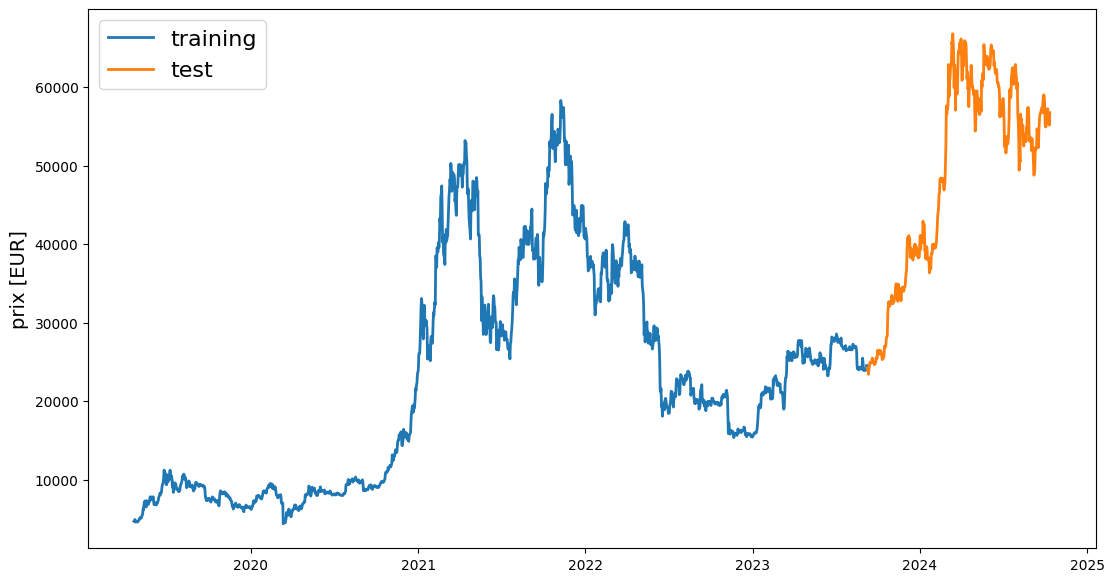

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('prix [EUR]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 1000
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - loss: 0.0111
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - loss: 0.0018
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - loss: 0.0017
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - loss: 0.0014
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - loss: 0.0014
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - loss: 0.0014
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - loss: 0.0015
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 0.0015
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - loss: 0.0014
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - loss: 0.0015
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - loss: 0.0018
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - loss: 0.0016
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - loss: 0.0013
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 262ms/step - loss: 0.0015
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


0.020518597284542285

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
print(preds)

time
2023-09-13    24324.589835
2023-09-14    25088.358409
2023-09-15    25383.282662
2023-09-16    24929.280574
2023-09-17    24777.753646
                  ...     
2024-10-07    57037.331283
2024-10-08    56960.067373
2024-10-09    56720.727445
2024-10-10    56808.464754
2024-10-11    56081.886026
Length: 395, dtype: float64


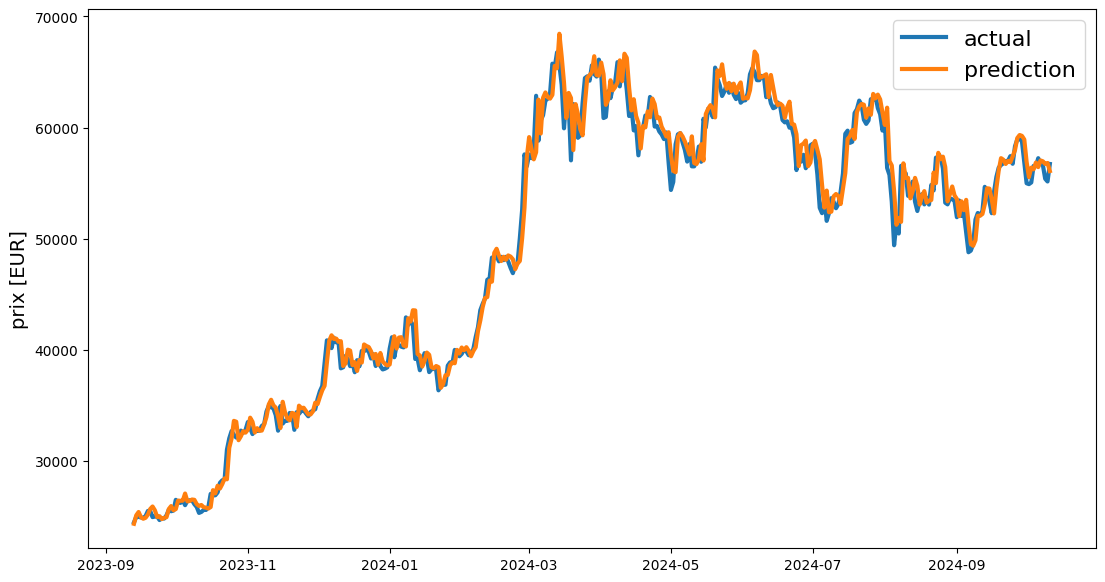

In [ ]:
line_plot(targets, preds, 'actual', 'prediction', lw=3)